# 감성 분석

## 0) Import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

## 1) 데이터 불러오기

In [2]:
df = pd.read_csv("../text_mining/총데이터.csv")
# df.shape

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1, random_state=42)
print('훈련용 리뷰의 개수 :', len(train))
print('테스트용 리뷰의 개수 :', len(test))

훈련용 리뷰의 개수 : 196587
테스트용 리뷰의 개수 : 21843


In [4]:
train.head()

,id,document,label
55108,5739157,그냥저냥 볼만한데..,1
177778,10184580,별점이 높을만 하다! 스포츠 관련 영화는 안보는데 끌려서 봤더니.. 내 감 아직 안...,1
208420,5379874,재밋다 ㅋ,1
39144,4774633,"갠찬았는데.. 어떻게보면 싸이코같지만, 많은생각을갖게만드는 영화",1
55080,8336803,전체적인 구성은 좋았지만 세밀한 디테일이 좀 부족한 영화,1


In [5]:
test.head()

,id,document,label
50798,4870266,지켜야 할 전통과 버려야 할 악습을 구분하라는 좋은 주제만이...,0
166003,3397622,그때로 돌아가고 있다.. 이 영화 1급공무원이 봤으면 한다.,1
123822,9735801,그냥 뮤지컬이라고 생각하고 음악에 몰입하면 한없이 즐거운 영화,1
31635,10246552,재밌게 잘 봤습니다 상영 후 시네마토크와 gv를 통해 영화에 대한 더 깊은 이해를 ...,1
21160,6800636,보라연기진짜못하던데그거때문에영화에집중도안되고ㅡㅡ,0


In [6]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (196587, 3) 
test shape => (21843, 3)


In [7]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

## 2) 훈련 데이터 라벨링 값 비율 확인

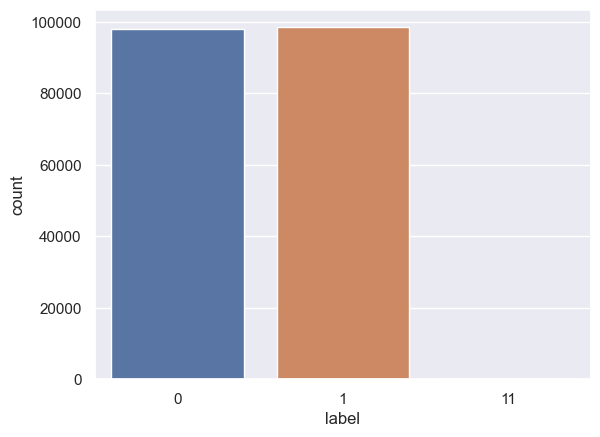

In [8]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

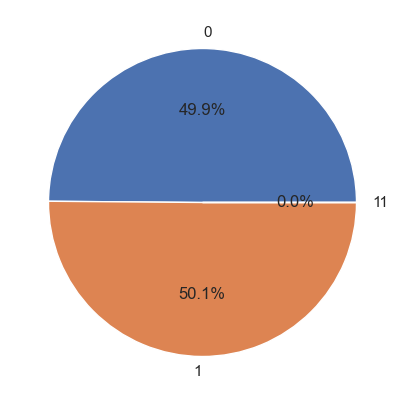

In [9]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 3) 훈련, 테스트 데이터 결측치 값 확인

In [10]:
train.isnull().sum()

id          12734
document        7
label           0
dtype: int64

In [11]:
test.isnull().sum()

id          1400
document       1
label          0
dtype: int64

## 4) 데이터 전처리
- 데이터 중복제거(drop_duplicates)  
- 결측치 제거(dropna)  
- 한국어 토크나이저를 활용한 토큰화(Komoran)  
- 불용어 제거(조사,구두점,접미사 종류)
- Bag of Words, word to index, index to word 구현  
- 문장 길이 분포와 적절 최대 문자 길이 지정  
- 최대 문자 길이에 따른 패딩 추가(pad_sequences)

In [12]:
import os

In [13]:
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-20\bin\server'

In [14]:
tokenizer = Komoran()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape => {test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                      'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                      'XSN', 'XSV', 'XSA']
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in range(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in range(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])
        X_test.append(temp)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [15]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (178920, 3) 
test shape => (20175, 3)


In [16]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [17]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 11.04784148270926
토큰 길이 최대: 1175
토큰 길이 표준편차: 10.725769538712829
설정 최대 길이: 32
전체 문장의 0.9496873351917426%가 설정값인 32에 포함됩니다.


### max_len = 32이 아닌 임의 값을 정해 진행했습니다.

In [18]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=50)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=50)

In [19]:
print(f"X_train 1번째 값 길이 : {len(X_train[0])}\nX_test 1번째 값 길이 : {len(X_test[0])}")

X_train 1번째 값 길이 : 50
X_test 1번째 값 길이 : 50


## 5) 모델링 - CNN

In [20]:
vocab_size = 30000
word_vector_dim = 32

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          960000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          2576      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 16)                0

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                  stratify=y_train, random_state=42)

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    batch_size=512, epochs=10, verbose=1)

Epoch 1/10
280/280 [==============================] - 6s 18ms/step - loss: 0.5773 - accuracy: 0.6900 - val_loss: 0.4481 - val_accuracy: 0.7874
Epoch 2/10
280/280 [==============================] - 5s 17ms/step - loss: 0.4355 - accuracy: 0.8044 - val_loss: 0.4265 - val_accuracy: 0.7979
Epoch 3/10
280/280 [==============================] - 5s 17ms/step - loss: 0.3853 - accuracy: 0.8326 - val_loss: 0.4282 - val_accuracy: 0.7978
Epoch 4/10
280/280 [==============================] - 5s 17ms/step - loss: 0.3433 - accuracy: 0.8530 - val_loss: 0.4443 - val_accuracy: 0.7947
Epoch 5/10
280/280 [==============================] - 5s 17ms/step - loss: 0.3037 - accuracy: 0.8713 - val_loss: 0.4650 - val_accuracy: 0.7868
Epoch 6/10
280/280 [==============================] - 5s 17ms/step - loss: 0.2707 - accuracy: 0.8864 - val_loss: 0.4917 - val_accuracy: 0.7886
Epoch 7/10
280/280 [==============================] - 5s 17ms/step - loss: 0.2425 - accuracy: 0.8978 - val_loss: 0.5319 - val_accuracy: 0.7834

In [26]:
# 모델 저장하기
from tensorflow.keras.models import save_model
save_model(model,'./data2/CNN/')

INFO:tensorflow:Assets written to: ./data2/CNN/assets


INFO:tensorflow:Assets written to: ./data2/CNN/assets


In [23]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

631/631 [==============================] - 1s 771us/step - loss: 0.6545 - accuracy: 0.7734
[0.6544895768165588, 0.7734324932098389]


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


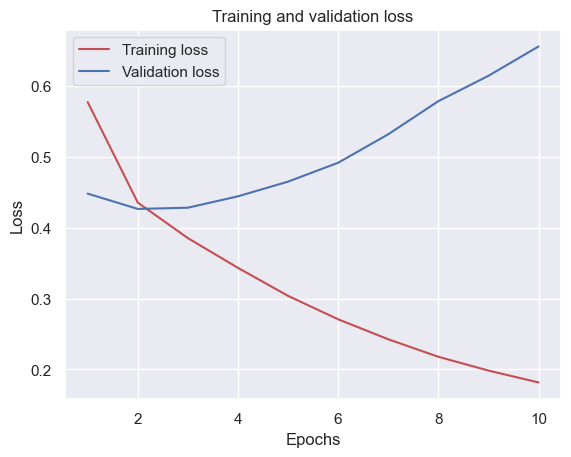

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()